Goal: find similarities within groups of users in order to cluster based on preferred reading genres.

**Links to resources:**

***Movie Recommendation Program** *
(links are pretty much the same but wording differs at times and one can be 
clearer to understand than the other and vice versa)

https://towardsdatascience.com/unsupervised-classification-project-building-a-movie-recommender-with-clustering-analysis-and-4bab0738efe6

https://programming.rhysshea.com/K-means_movie_ratings/

***Helper File Used Movie Project Utilizes***
https://gist.github.com/Rhysoshea/18f4af800179a7fa53d29194ef4dca6f



**Notes:**
I was able to cluster by 2 and three genres by just quickly hand manipulating our data in Excel and getting the proper format for these algorithms. Our final data set would need a few modifications to work with this example. I'm not good with pandas but if we can get our data in the same format we would be all set, maybe one of you can do it before we meet Sat. afternoon.

Additionaly, you'll see in the example that they handle the issue of NaN values for missing user reviews by re-sorting all rating data by movies that have the most ratings and the users that have entered the most ratings so that their data is more dense to perform the clustering. Another thing is that we probably should not cluster ALL of the user reviews, just the top X% of whatever is the result from the aforementioned sorting step.

In [82]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import helper

In [69]:
# Load average user ratings by genre from custom .csv w/ 2 genres
avg_ratings = pd.read_csv('user-avg-rating-2-genres.csv')
avg_ratings.head()

,user_id,avg_fantasy,avg_mystery
0,5,4.500000,4.200000
1,10,4.000000,4.000000
2,11,3.500000,4.000000
3,14,3.500000,4.000000
4,23,3.666667,3.066667


In [70]:
# Create delimited subset of data to get user ratings who prefer either
# fantasy or mystery

def preferred_genre_data(avg_ratings, score_limit_1, score_limit_2):
    
    preferred_data = avg_ratings[((avg_ratings['avg_fantasy'] < score_limit_1 - 0.2) & (avg_ratings['avg_mystery'] > score_limit_2)) |
                                 ((avg_ratings['avg_mystery'] < score_limit_1) & (avg_ratings['avg_fantasy'] > score_limit_2))]
    
    preferred_data = pd.concat([preferred_data[:300], avg_ratings[:2]])
    
    preferred_data = pd.DataFrame(preferred_data.to_records())
    
    return preferred_data

preferred_data = preferred_genre_data(avg_ratings, 3.0, 2.5)
preferred_data = preferred_data.drop('index',axis=1)

print( "Number of records: ", len(preferred_data))

preferred_data.head()

Number of records:  297


,user_id,avg_fantasy,avg_mystery
0,27,4.0,2.00
1,36,3.6,2.50
2,44,3.5,2.75
3,48,5.0,1.00
4,60,5.0,2.00


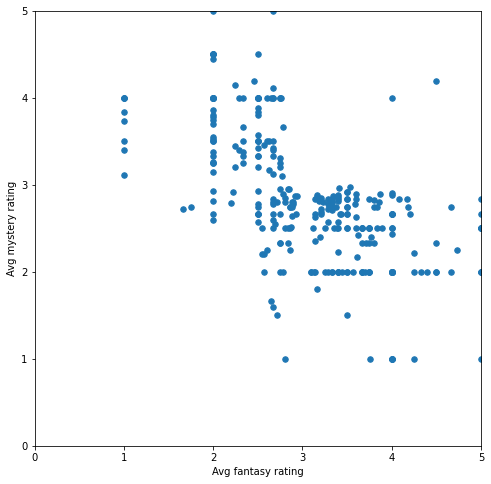

In [71]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

draw_scatterplot(preferred_data['avg_fantasy'],'Avg fantasy rating',
                 preferred_data['avg_mystery'], 'Avg mystery rating')

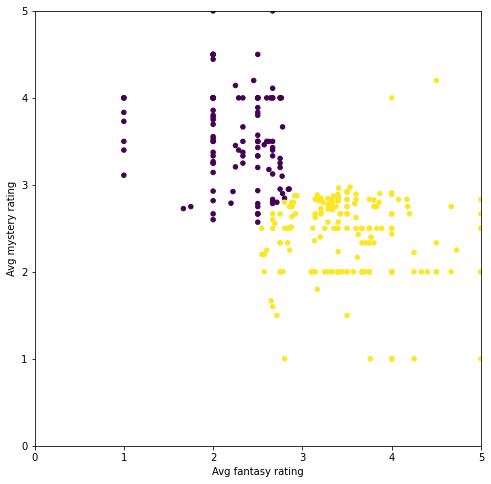

In [72]:
X = preferred_data[['avg_fantasy','avg_mystery']].values

from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(preferred_data, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg fantasy rating')
    ax.set_ylabel('Avg mystery rating')
    
    clustered = pd.concat([preferred_data.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_fantasy'], clustered['avg_mystery'], c=clustered['group'], s=20, cmap=cmap)
    
draw_clusters(preferred_data, predictions)

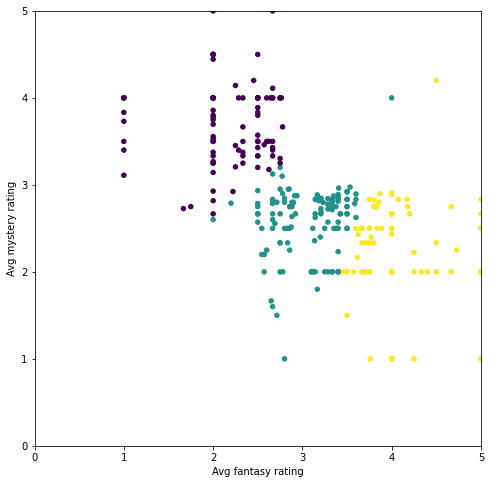

In [73]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
draw_clusters(preferred_data, predictions_2)

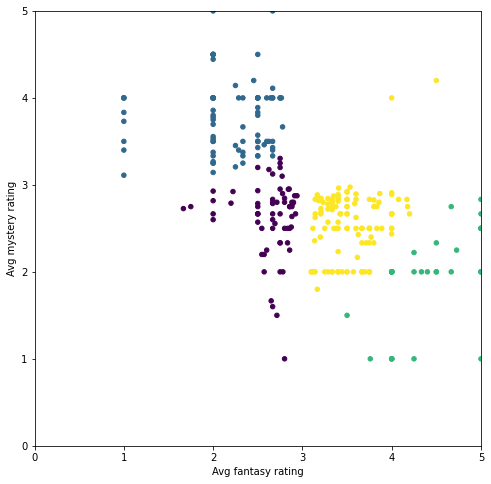

In [74]:
# Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters=4)

# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
draw_clusters(preferred_data, predictions_3)



C:\Users\12033\Documents\WPI\Senior\DS3001\project\helper.py:35: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (237). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
C:\Users\12033\Documents\WPI\Senior\DS3001\project\helper.py:35: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (242). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
C:\Users\12033\Documents\WPI\Senior\DS3001\project\helper.py:35: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (247). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
C:\Users\12033\Documents\WPI\Senior\DS3001\project\helper.py:35: ConvergenceWarning: Number of distinct clusters (232) found smaller than n_clusters (252). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
C:\Users\12033\Documents\WPI\Senior\DS3001\project\h

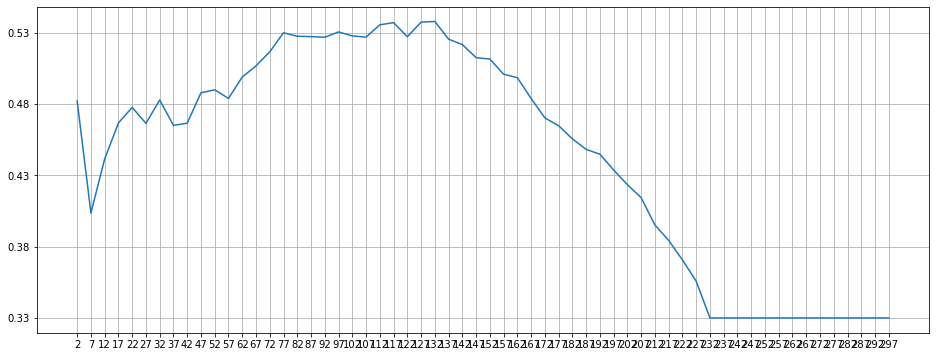

In [75]:
# Determinine the correct k number of clusters

# This didnt really work out so I just did trial and error in the
# cell below to find when cluster # became too high
# by looking for when is started getting the clustering incorrect

df = preferred_data[['avg_fantasy','avg_mystery']]

possible_k_values = range(2, len(X)+1, 5)

# Create function to find clustering error
def cluster_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')


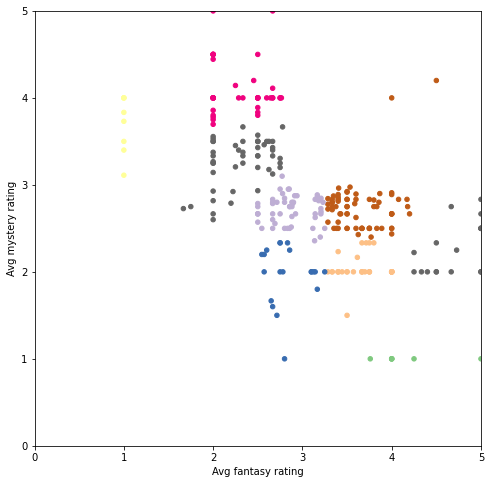

In [76]:
# Create an instance of KMeans to find clusters
kmeans_4 = KMeans(n_clusters=9)

# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# Plot
draw_clusters(preferred_data, predictions_4, cmap='Accent')

In [86]:
# Load avg user ratings for all genres

# TODO replace tag_id # number with words

all_avg_ratings = pd.read_csv('final_ratings_with_NaN.csv')
all_avg_ratings.head()

,user_id,1642,1691,1746,2056,2313,2690,3027,3611,4594,...,28422,28466,29005,29452,30208,30241,30358,31254,32130,33114
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN
4,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0


In [87]:
'''
def sort_by_rating_density(all_avg_ratings, n_genres, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
'''

# choose the number of movies and users and sort
n_genres = 30
n_users = 18
most_rated_genres_users = helper.sort_by_rating_density(all_avg_ratings, n_genres, n_users)

# Print the result
print('dataset dimensions: ', most_rated_genres_users.shape)
most_rated_genres_users.head()


dataset dimensions:  (18, 30)


,user_id,11743,21689,8055,1642,14487,26138,11305,4605,7457,...,26771,27669,27095,6750,9886,11221,32130,3611,14821,4594
1406,1407,3.837209,3.909091,3.800000,3.823529,4.090909,3.666667,3.500000,4.125000,3.500000,...,4.0,4.000000,2.500000,3.166667,3.500000,3.800000,4.000000,4.000000,4.500000,3.333333
1255,1256,3.282051,3.857143,3.409091,3.363636,3.200000,3.083333,3.800000,3.857143,4.000000,...,4.0,4.000000,4.000000,2.888889,2.750000,3.200000,4.000000,4.000000,3.666667,4.000000
1439,1440,3.479167,3.848485,3.381818,3.372093,3.632353,3.147059,3.357143,3.727273,3.741935,...,3.8,4.000000,4.000000,2.705882,3.333333,3.571429,3.545455,3.777778,3.250000,4.500000
1427,1428,3.716667,4.000000,3.617647,3.650000,3.800000,3.647059,3.333333,4.125000,3.500000,...,2.5,3.666667,3.714286,3.416667,3.600000,3.600000,4.333333,4.250000,4.000000,4.000000
3687,3688,4.115385,4.045455,4.105263,4.173913,4.179487,4.000000,4.200000,4.142857,4.104167,...,4.0,4.500000,4.000000,4.000000,4.125000,4.000000,4.000000,4.250000,4.000000,4.000000


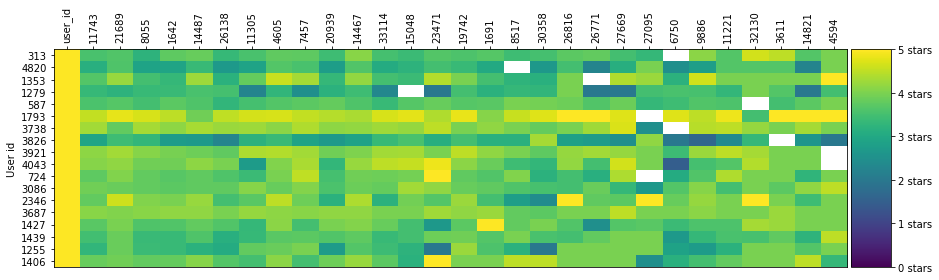

In [83]:
helper.draw_movies_heatmap(most_rated_genres_users)

In [85]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_genres_users).to_coo())

<ipython-input-85-a456f5328359>:1: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_genres_users).to_coo())


TypeError: SparseDataFrame() takes no arguments

In [26]:
import pandas as pd
from sklearn.cluster import KMeans

all_avg_ratings = pd.read_csv('final-csv/absolute-final.csv')
x_all_genres = all_avg_ratings[['1642','1691','1746','2056','2313','2690','3027','3611','4594','4605','5870','5951','6750','6960','7077','7224','7457','7725','7739','8055','8130','8517','8755','8922','9318','9886','10064','10245','10304','10641','10708','10731','10825','10866','11152','11221','11305','11425','11743','11937','12452','13446','13547','13643','13873','14134','14467','14487','14527','14821','15048','15505','16651','17639','18869','19052','19742','20673','20939','21024','21195','21672','21689','22973','23005','23334','23471','23535','23569','23605','23743','23831','23909','25562','25685','26138','26371','26771','26816','27095','27438','27669','28247','28259','28422','28466','29005','29452','30208','30241','30358','31254','32130','33114'
]]
x_all_genres_values = x_all_genres.values

# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(x_all_genres_values)

[5 6 4 0 5 6 3 6 4 5]


In [ ]:
import helper

#max possible k values
possible_k_values = range(2, len(x_all_genres_values)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, x_all_genres_values) for k in possible_k_values]

In [25]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

      user_id      1642      1691  1746  2056      2313  2690  3027  3611  \
0           1  3.000000  3.000000   3.0   3.0  3.000000   3.0   3.0   4.0   
1           2  3.000000  3.000000   3.0   3.0  3.000000   3.0   3.0   5.0   
2           3  3.000000  3.000000   3.0   3.0  3.000000   3.0   3.0   3.0   
3           4  2.000000  3.000000   3.0   3.0  3.000000   3.0   3.0   3.0   
4           5  4.000000  3.000000   3.0   3.0  3.000000   3.0   3.0   3.0   
...       ...       ...       ...   ...   ...       ...   ...   ...   ...   
4995     4996  3.666667  3.666667   3.0   3.0  3.000000   3.0   3.0   3.0   
4996     4997  3.000000  5.000000   3.0   3.0  3.000000   3.0   3.0   3.0   
4997     4998  3.750000  3.000000   3.0   3.0  3.000000   3.0   3.0   3.0   
4998     4999  3.000000  3.000000   3.0   3.0  4.333333   3.0   3.0   3.0   
4999     5000  3.666667  3.000000   3.0   3.0  3.000000   3.0   3.0   3.0   

      4594  ...  28466  29005  29452  30208  30241  30358  31254  32130  \
